<a href="https://colab.research.google.com/github/developer-onizuka/MachineLearningOnAWS/blob/main/BERT_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. ゴール

- Transformer (Attention is All you needに示されるAttention機構)の概要を理解する。（2章）<br>
- Pipelineを使って、任意のモデルで推論を行う。（3章）<br>
- BERTと呼ばれるエンコーダー型の言語モデルを使い、分類器を作る。（4, 5, 6章）<br>
(今回の例は、エンコーダー含めたモデル全体の重みを計算するフルファインチューニング)
- メモリ効率の良いファインチューニング(LoRA)を用いて、分類器を作る。（7章）

## 2. Transformerについて

## 2-1. 従来モデルの問題点

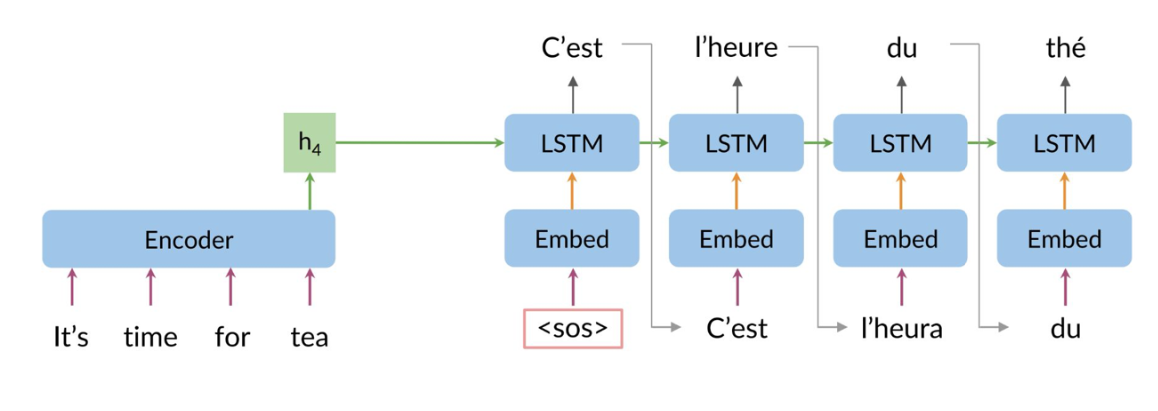

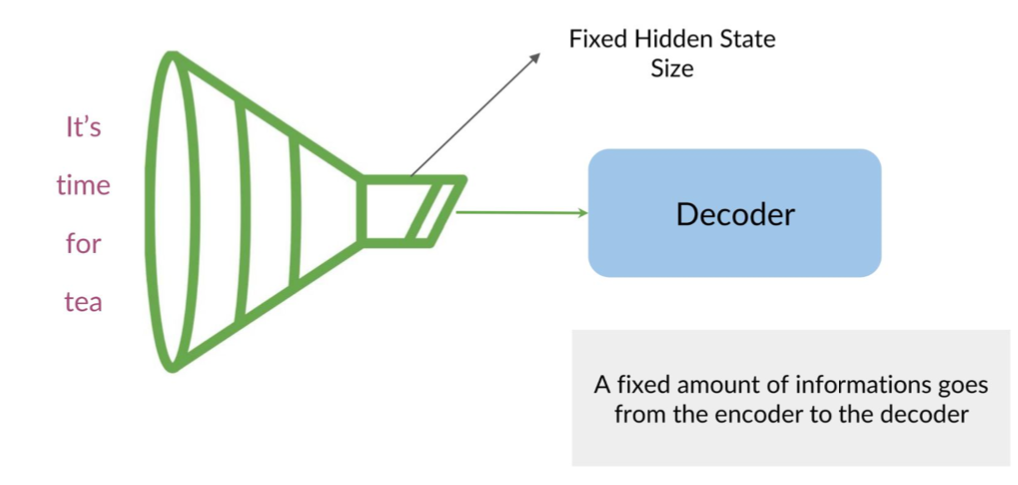

## 2-2. Attention機構

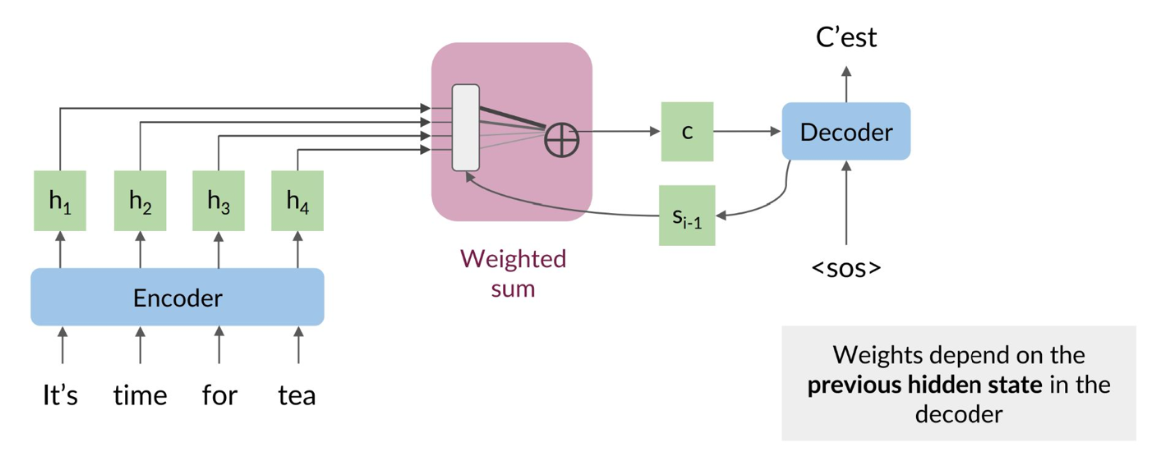

## 2-3. Transformerのブロック図

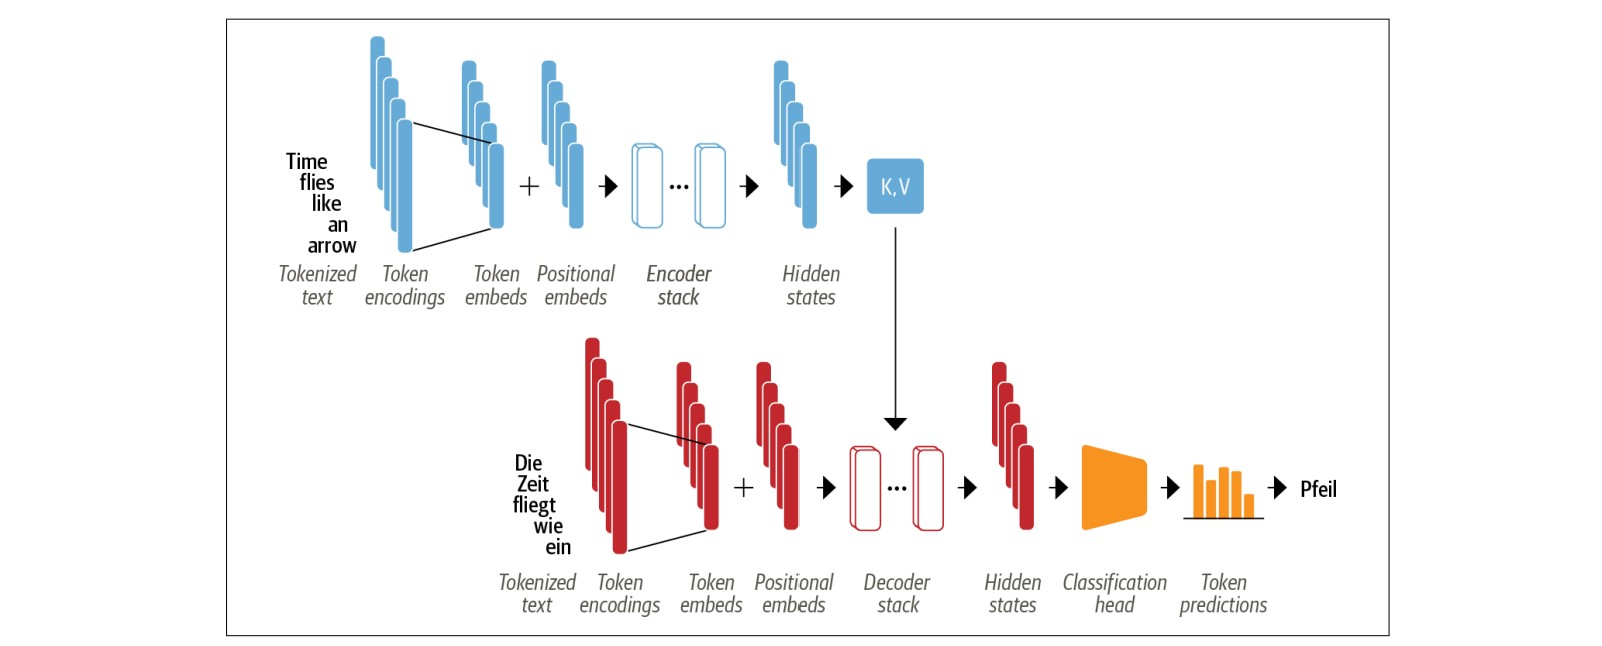

## 2-4. 各用語

| 用語 | 説明 (Japanese) |
|----------------|----------------|
| **Tokenized text** | 入力テキストは最初にトークン化され、単語やサブワードに分割されます。 |
| **Token encodings** | 各トークンには一意のエンコーディングが割り当てられます。<br>このエンコーディングは、トークンの意味とシーケンス内での位置を表します。 |
| **Token Embedding** | トークンのエンコーディングは、トークン埋め込み層を通過します。<br>この層は、エンコーディングをベクトル表現に変換し、トランスフォーマーモデルで使用できるようにします。 |
| **Positional Embedding** | 位置埋め込み層は、トークン埋め込みに位置情報を加えます。<br>この情報は、シーケンス内の各トークンの位置を表します。 |
| **Encode Stack** | トークン埋め込みと位置埋め込みは、エンコーダ層のスタックを通過します。<br>各エンコーダ層はSelf Attentionの仕組みを適用します。<br>Self Attention機構により、モデルはシーケンスの異なる部分間の長距離依存関係を学習できます。 |
| **Hidden States** | エンコードスタックの出力は、一連の隠れ状態となります。<br>これらの隠れ状態は、入力シーケンスの表現を示します。 |
| **Decoder Stack** | 隠れ状態はデコーダ層のスタックを通過します。<br>デコーダ層はAttention機構と、入力シーケンスに注意を向けるAttention機構を適用します。<br>Attention機構により、モデルは出力シーケンスを生成する際に、入力シーケンスの異なる部分に焦点を当てることができます。 |
<br>

## 2-5. Self Attentionについて

Self-Attention は、各単語が 文中の他の単語との関連性を学習する 仕組み。 Transformerモデルの中心的な技術で、遠く離れた単語間の関係 も捉えられる。 Query (Q), Key (K), Value (V) のベクトルを使い、どの単語が重要か判断し情報を取得する。

## 2-6. Key, Value, Queryの働き

Transformerのエンコーダーでは、K (Key), V (Value), Q (Query) の3つのベクトルが Self-Attentionの計算で使用される。なお、これらのベクトルは、エンコーダーに入力される埋め込みベクトルから生成される。

- Q (Query) : 問いかけ<br>
入力されたトークン（単語やサブワード）が、どのトークンに注目すべきかを決めるための「検索ベクトル」。自身の意味を他の単語と比較するための指標になる。

- K (Key) : 検索対象<br>
各トークンがどの程度「関連性を持つか」を判断するための「キー（鍵）」となるベクトル。Query とのスコアを計算し、注意を向けるべき単語を決める。

- V (Value) : 情報の抽出<br>
実際に情報を持つ「値ベクトル」。Self Attention機構によって、最も関連性の高い Key に対応する Value が強調される。

Query (Q) と Key (K) の 内積（dot product） を計算し、スコアを出す。スコアを Softmax で正規化し、どの単語にどれくらいの注意を向けるかを決める。Value (V) にスコアをかけて、出力を生成。数式的には、以下に示されるとおりになる。

$$
\text{Attention}(Q, K, V) = \text{softmax} \left(\frac{Q K^T}{\sqrt{d_k}}\right) V
$$




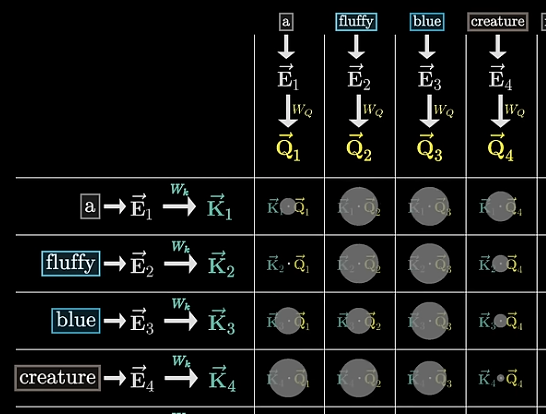

> https://www.youtube.com/watch?v=j3_VgCt18fA

## 2-7. エンコーダー、デコーダー機能の特徴

| 分類 | 主なモデル | 主な用途 |
|-------------|-----|------------------------------|
| **Encoder-Decoder Models** | BART, T5 | 機械翻訳、テキスト要約、データ生成、コード補完 |
| **Encoder-Only Models** | BERT, RoBERTa, DistilBERT | 文書分類、固有表現抽出、検索システム、文書埋め込み |
| **Decoder-Only Models** | GPT, GPT-2, GPT-3, LLaMA | テキスト生成、対話型AI、コード生成、文章補完 |


## 3. Hugging Faceを使った推論実行

## 3-1. Text Classification

In [ ]:
!pip install -U transformers
!pip install -U sentencepiece
!pip install -U sacremoses

In [ ]:
from transformers import pipeline
import pandas as pd

In [ ]:
classifier = pipeline("text-classification", model = "SamLowe/roberta-base-go_emotions")

text = "I'm not sure which is better for you."
outputs = classifier(text)

In [ ]:
pd.DataFrame(outputs)

## 3-2. Question Answering

In [ ]:
text = """
I am very interested in President Trump's tariff policy.
"""

reader = pipeline("question-answering")
question = "Who is responsible for this issue?"

outputs = reader(question=question, context=text)

In [ ]:
pd.DataFrame([outputs])

## 3-3. Translation

In [ ]:
translator = pipeline('translation', model='Mitsua/elan-mt-bt-en-ja')

outputs = translator(text)

In [ ]:
outputs

## 3-4. Text Generation

In [ ]:
from transformers import set_seed
set_seed(0)

In [ ]:
generator = pipeline("text-generation", model="gpt2-large")

prompt = "I've been to New York but I was "
outputs = generator(prompt, max_length=128)

In [ ]:
outputs

## 4. 事前学習済みモデルとファインチューニングの概要



- 事前学習済みモデル：大規模データで事前に学習した、汎用的な機械学習モデル
- ファインチューニング：事前学習済みモデルのパラメータを微調整する手法

ファインチューニングでは、各タスクに特化したモデルを作るために、ニューラルネットワークの最終層に新たな層を追加する。その後、追加した層と学習済みモデルの一部または全体を、追加で学習することになる。

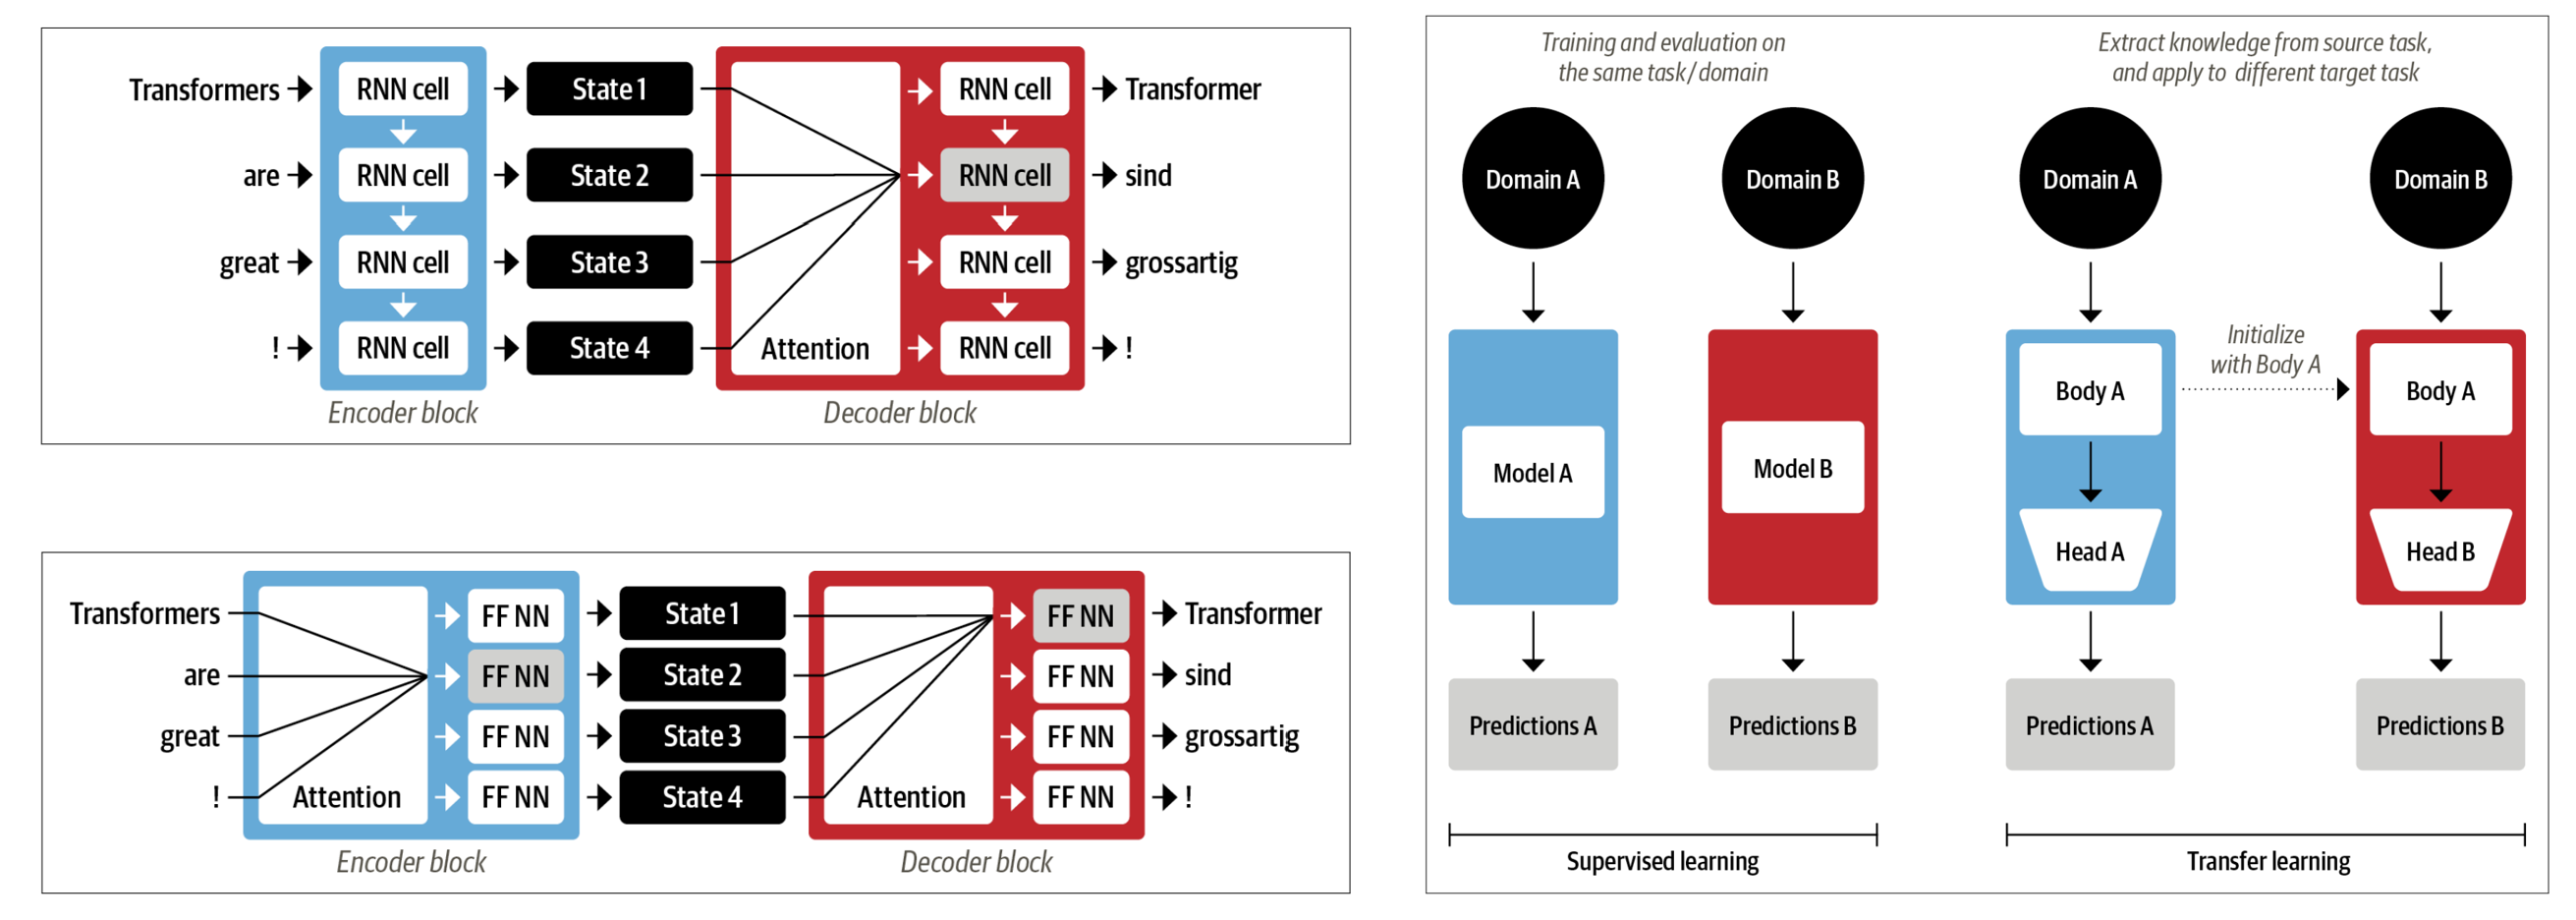

## 5. Hugging Faceを使ったファインチューニング

## 5-1. データエンジニアリング

In [ ]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install seaborn --upgrade

In [ ]:
import pandas as pd

df = pd.read_parquet("https://datasets-documentation.s3.eu-west-3.amazonaws.com/amazon_reviews/amazon_reviews_2010.snappy.parquet",columns=["star_rating","review_body"])


In [ ]:
for i in range(1,6):
    print("star_rating: ", i)
    print(df[df['star_rating'] == i].count())
    print('-------------------------')

In [ ]:
for i in range(1,6):
    new_df = 'df' + str(i)
    globals()[new_df] = df[df['star_rating'] == i].sample(n=2000)

In [ ]:
df = pd.concat([df1,df2,df3,df4,df5])
df.count()

In [ ]:
df['review_body'] = df['review_body'].astype("string")
df['star_rating'] = df['star_rating'].astype("int64")

In [ ]:
df.info()
df.isnull().sum()

In [ ]:
df['review_body']

In [ ]:
df = df.rename(columns={'review_body': 'text', 'star_rating': 'label'})

In [ ]:
df['text']

In [ ]:
df['label'].value_counts()

In [ ]:
df["label"] = df["label"] - 1

In [ ]:
df['label'].value_counts()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
label_counts = df['label'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

## 5-2. トークナイザーの定義

In [ ]:
from transformers import AutoTokenizer

base_model = "bert-base-cased"
#base_model = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(base_model)

text = "This product is very good."
encoded_text = tokenizer(text)
print(encoded_text)

## 5-3. データセットの分割

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'])
test_df, validation_df = train_test_split(test_df, test_size=0.5, stratify=test_df['label'])

train_df.shape, test_df.shape, validation_df.shape

In [ ]:
from datasets import Dataset, DatasetDict, Features, Value, ClassLabel

dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df, preserve_index=False),
    'test': Dataset.from_pandas(test_df, preserve_index=False),
    'validation': Dataset.from_pandas(validation_df, preserve_index=False)
})

dataset

In [ ]:
dataset['train'].features

In [ ]:
dataset['train']['label'][:10]

## 5-4. データセットのトークン化

In [ ]:
def tokenize(temp):
    result = tokenizer(temp['text'], padding=True, truncation=True)
    return result

print(tokenize(dataset['train'][:2]))

In [ ]:
review_encoded = dataset.map(tokenize, batched=True, batch_size=None)

## 5-5. ラベルのマッピング

In [ ]:
# label2id, id2label
label2id = {'Excellent' : 4, 'Good' : 3, 'Average' : 2, 'Below Average' : 1, 'Poor' : 0}
id2label = {v:k for k,v in label2id.items()}

label2id, id2label

## 5-6. ベースモデルを読み込む

In [ ]:
from transformers import AutoModel
import torch

In [ ]:
base_model

In [ ]:
model = AutoModel.from_pretrained(base_model)

In [ ]:
model

In [ ]:
model.config.id2label

In [ ]:
model.config

## 5-7. 分類器を組み込む

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoConfig

num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(base_model, label2id=label2id, id2label=id2label, num_labels=num_labels)
model = AutoModelForSequenceClassification.from_pretrained(base_model, config=config).to(device)

In [ ]:
model.config

In [ ]:
model

## 5-8. モデルのパラメータ数

パラメータは特定の単語間の関連性や文脈の理解、さらには複雑なパターンの認識に直接関与するため、パラメータが正確に調整されることで、 AI は自然な文章生成や高度な推論が可能になる。

In [ ]:
def param_count(model_example):
    n = 0
    blocks = [
        ('モデルのEmbeddings層', model_example.bert.embeddings), # Access embeddings through model_example.bert
        ('モデルのEncoder層', model_example.bert.encoder), # Access encoder through model_example.bert
        ('モデルのPooler層', model_example.bert.pooler), # Access pooler through model_example.bert
    ]
    for block in blocks:
        print('-'*10, block[0], '-'*10)
        if block[0] == 'モデルのEncoder層':  # Encoder層は大きいので layer ごとにまとめる．
            for i, layer in enumerate(block[1].layer):
                n_layer = 0
                for name, param in layer.named_parameters():
                    n_ = param.numel()
                    if i == 0:  # 最初の1層だけ詳細に表示する．
                        print(name, n_)
                    n_layer += n_
                print(f'Encoder層内の{i}層目計', n_layer)
                n += n_layer
        else:
            for name, param in block[1].named_parameters():
                n_ = param.numel()
                print(name, n_)
                n += n_

    print('='*10, 'パラメータ数', '='*10)
    return n

In [ ]:
param_count(model)

In [ ]:
model.classifier

(classifier): Linear(in_features=768, out_features=5, bias=True)
パラメータ数の計算は次のようになる。

- 重み (weights) の数: in_features × out_features = 768 × 5 = 3,840

- バイアス (bias) の数: out_features = 5

- 合計パラメータ数: 3,840 + 5 = 3,845

In [ ]:
# 分類器のパラメータ数を取得
classifier_params = sum(p.numel() for p in model.classifier.parameters())
print(f"分類器のパラメータ数: {classifier_params}")

In [ ]:
# モデル全体のパラメータ数を取得
total_params = sum(p.numel() for p in model.parameters())
print(f"モデル全体のパラメータ数: {total_params}")

## 5-9. モデルの学習（フルファインチューニング）

In [ ]:
# エンコーダー部分のパラメータを固定（分類器のみ学習する場合は、Flaseを選択）
for param in model.base_model.parameters():
    #param.requires_grad = False
    param.requires_grad = True

In [ ]:
from transformers import TrainingArguments

batch_size = 32 #16
training_dir = "bert_base_train_dir"
gradient_accumulation_steps = 2

training_args = TrainingArguments(
    output_dir = training_dir,
    overwrite_output_dir = True,
    run_name = 'experiment_v1',
    num_train_epochs = 1,
    learning_rate = 2e-5, # 1e-1, #2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    weight_decay = 0.01,
    eval_strategy = 'epoch', #'no'
    disable_tqdm = False,
    report_to = 'none'
)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}

In [ ]:
!nvidia-smi

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model, args=training_args,
    compute_metrics = compute_metrics,
    train_dataset = review_encoded['train'],
    eval_dataset = review_encoded['validation'],
    tokenizer = tokenizer
)

In [ ]:
trainer.train()

## 5-10. モデルの評価

In [ ]:
preds_output = trainer.predict(review_encoded['test'])
preds_output.metrics

In [ ]:
import numpy as np
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = review_encoded['test'][:]['label']

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

In [ ]:
label2id

In [ ]:
# plot confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt='d', cbar=False, cmap='Reds')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

## 5-11. モデルの保存

In [ ]:
trainer.save_model("bert-base-cased-amazon-review-model")

## 6. モデルの推論試行

In [ ]:
# use pipeline for prediciton
from transformers import pipeline

classifier = pipeline('text-classification', model= 'bert-base-cased-amazon-review-model')

In [ ]:
classifier("I like this toy. I recommned this to my friends!")

In [ ]:
classifier("Disapointed")

In [ ]:
text = ["I will not buy it again", "I bought my son this product. He has been so satisfied.", "I am very happy."]

In [ ]:
classifier(text)

## 7. PEFTによるファインチューニング

## 7-1. ライブラリのインストール

In [ ]:
!pip install peft

## 7-2. LoRA Config

LoRA（Low-Rank Adaptation）は、パラメータ効率の良いファインチューニング（PEFT）の一種で、事前学習済みモデルの重みを固定したまま、低ランク行列を追加して特定のタスク向けに適応させる技術。<br>

| task_type                           | 説明                                      |
|-------------------------------------|------------------------------------------|
| peft.TaskType.SEQ_CLS              | テキスト分類（例：感情分析）             |
| peft.TaskType.SEQ_2_SEQ_LM         | テキスト生成（例：要約、翻訳）           |
| peft.TaskType.CAUSAL_LM            | 自然な文章生成（例：GPT系モデル）        |
| peft.TaskType.TOKEN_CLS            | トークン分類（例：固有表現認識）         |
| peft.TaskType.QUESTION_ANS         | 質問応答モデル（例：文書からの情報抽出） |
| peft.TaskType.IMAGE_CLS            | 画像分類（例：ViTなどの視覚モデル）      |


In [ ]:
import peft

In [ ]:
peft_config = peft.LoraConfig(
    task_type=peft.TaskType.SEQ_CLS,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    inference_mode=False,
    target_modules="all-linear",
)

## 7-3. PEFTモデル構築

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoConfig

num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(base_model, label2id=label2id, id2label=id2label, num_labels=num_labels)
model = AutoModelForSequenceClassification.from_pretrained(base_model, config=config).to(device)

In [ ]:
peft_model = peft.get_peft_model(model, peft_config)
peft_model

In [ ]:
peft_model.classifier

## 7-4. PEFTモデルのパラメータ数

In [ ]:
peft_model.print_trainable_parameters()

In [ ]:
param_count(peft_model)

In [ ]:
# 分類器のパラメータ数を取得
classifier_params = sum(p.numel() for p in model.classifier.parameters())
print(f"分類器のパラメータ数: {classifier_params}")

In [ ]:
# モデル全体のパラメータ数を取得
total_params = sum(p.numel() for p in peft_model.parameters())
print(f"モデル全体のパラメータ数: {total_params}")

In [ ]:
def list_trainable_params(model):
    """
    モデル内の学習可能なパラメータ（requires_grad=True）をリストアップするスクリプト
    """
    trainable_params = {}
    total_trainable = 0

    for name, param in model.named_parameters():
        if param.requires_grad:
            param_count = param.numel()  # パラメータの総数
            trainable_params[name] = param_count
            total_trainable += param_count

    # 結果の表示
    print(f"Trainable Parameters: {total_trainable}")
    print("-" * 40)
    for name, count in trainable_params.items():
        print(f"{name}: {count}")

    return trainable_params

In [ ]:
list_trainable_params(peft_model)

## 7-5. PEFTモデルの学習（ファインチューニング）

In [ ]:
from transformers import TrainingArguments, Trainer

batch_size = 32
training_dir = "peft_bert_base_train_dir"
gradient_accumulation_steps = 2

training_args = TrainingArguments(
    output_dir = training_dir,
    overwrite_output_dir = True,
    run_name = 'experiment_v1',
    num_train_epochs = 1,
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    weight_decay = 0.01,
    eval_strategy = 'epoch', #'no'
    disable_tqdm = False,
    report_to = 'none'
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model, args=training_args,
    compute_metrics = compute_metrics,
    train_dataset = review_encoded['train'],
    eval_dataset = review_encoded['validation'],
    tokenizer = tokenizer
)

In [ ]:
trainer.train()

## 7-6. PEFTモデルの評価

In [ ]:
preds_output = trainer.predict(review_encoded['test'])
preds_output.metrics

In [ ]:
import numpy as np
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = review_encoded['test'][:]['label']

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

In [ ]:
label2id

In [ ]:
# plot confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt='d', cbar=False, cmap='Reds')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

## 7-7. PEFTモデルの保存

In [ ]:
trainer.save_model("peft-bert-base-cased-amazon-review-model")

## 7-8. PEFTモデルの推論試行

In [ ]:
# use pipeline for prediciton
from transformers import pipeline

classifier = pipeline('text-classification', model= 'peft-bert-base-cased-amazon-review-model')

In [ ]:
classifier("I like this toy. I recommned this to my friends!")

In [ ]:
classifier("Disapointed")

In [ ]:
text = ["I will not buy it again", "I bought my son this product. He has been so satisfied.", "I am very happy."]

In [ ]:
classifier(text)